In [1]:
#Volume of tweets, retweets, quote counts

In [2]:
#similarity of replies

#### **This notebook checks the activity difference**

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
import sys
import os
import re

import importlib

#### packages
import helper.strategy_helper as st_hp
import helper.visualization as vz_hp
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config_hp
import helper.twitter_helper as twitter_hp
import helper.pandas_helper as pd_hp

#### **Load data**

In [48]:
config = config_hp.config()
balanced = config['COMBINED']

pos_replier = balanced['io_conversation']

df_pos = pd.read_pickle(pos_replier)

df_pos.columns

Index(['tweet_text', 'conversation_id', 'replier_tweetid', 'replier_userid',
       'poster_userid', 'poster_tweetid', 'tweet_time', 'tweet_language',
       'replier_label', 'year', 'campaign', 'tweet_label', 'tweet_time_year'],
      dtype='object')

In [50]:
df_pos.loc[df_pos['replier_label'] == 1]['replier_userid'].nunique()

19436

In [51]:
# config = config_hp.config()
# balanced = config['BALANCED']

# pos_replier = balanced['balanced_pos_replier']

# df_pos = pd.read_pickle(pos_replier)

# df_pos.columns

In [5]:
# df_pos.info()

In [52]:
df_pos['replier_userid'] = df_pos['replier_userid'].astype(int)

In [53]:
df_pos_1 = df_pos.loc[df_pos['replier_label'] == 1]['replier_userid']

In [54]:
df_pos_0 = df_pos.loc[df_pos['replier_label'] == 0]['replier_userid']

#### **POS retweet, org tweet, quote**

In [55]:
all_campaigns = st_hp.bundle_campaign(bundle=False)

In [56]:
config = config_hp.config()
path = config['PATHS']

derived_path = path['derived_path']
all_tweet_data = path['all_tweet_data']
plot_path = path['plot_path']

In [57]:
def get_path(path, 
             year, 
             campaign,
            ):
    '''
    Gets path to control and IO tweet file
    
    :param path: path to the directory where tweet is present
    :param year: year of compaign
    :param campaign: name of campaign
    :param check_control: whether to check if control is present
    
    return list
    '''
    
    ops_file_path = os.path.join(path, 
                                 year, 
                                 campaign, 
                                 f'{campaign}_tweets.pkl.gz')
    control_file_path = os.path.join(path, 
                                     year, 
                                     campaign, 
                                     'DriversControl', 
                                     f'{campaign}_control.pkl.gz')
    
    if os.path.isfile(control_file_path) == False:
        control_file_path = os.path.join(path, 
                                     year, 
                                     campaign, 
                                     'DriversControl', 
                                     f'{campaign}_tweets_control.pkl.gz')
        
    ops_flag = os.path.isfile(ops_file_path) == True
    
    if ops_flag:
        return {'ops': ops_file_path,
                'control': control_file_path
               }
    
    print('Files not found')
    
    return None

In [1]:
df_all = pd.DataFrame()
for year in all_campaigns:
    
    camp_year = year.split('_')[0]

    for campaign in all_campaigns[year]:
        print(campaign)

        print(f'\n ------START: {year}: {campaign} ------- \n')

        data_path = get_path(all_tweet_data, year, 
                             campaign)

        data = st_hp.read_ops_control_data(data_path['ops'],
                                        data_path['control'], 
                                           ['ops'])
        df_test = data['ops']

        if len(df_test) == 0:
            print(f'\n ------END: {year}: {campaign} ------- \n')
            continue

        
        df_found = df_test.loc[df_test['userid'].isin(
            df_pos_1
        )]
        
        camp_year = year.split('_')[0]
        
        df_found['year'] = camp_year
        
        if len(df_found) != 0:
            
            df_all = df_all.append(df_found, ignore_index=True)
            
            print(len(df_all))
            

#### **All activity**

In [59]:
def get_userid_created_at(df):
    '''
    Gets the userid and created_at information for individual accounts
    '''
    
    return df[['replier_userid', 'created_at_year']].drop_duplicates()

In [60]:
print(df_all.columns)

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_userid',
       'in_reply_to_tweetid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'year', 'poll_choices'],
      dtype='object')


In [62]:
df_pos.columns

Index(['tweet_text', 'conversation_id', 'replier_tweetid', 'replier_userid',
       'poster_userid', 'poster_tweetid', 'tweet_time', 'tweet_language',
       'replier_label', 'year', 'campaign', 'tweet_label', 'tweet_time_year'],
      dtype='object')

In [63]:
df_activity_count = df_all.groupby(['userid',
                                    'year'
                                   ])['tweetid'].size().reset_index(name='count')

df_1 = df_all[['userid', 'account_creation_date']].drop_duplicates()

df_activity_count = df_activity_count.merge(df_1,
                                            on='userid'
                                           )

In [64]:
df_activity_count.head(1)

,userid,year,count,account_creation_date
0,12148412,2019,464,2008-01-12


In [65]:
df_activity_count = df_activity_count.rename(
    columns={"year": "detected_year"})

In [67]:
# df_activity_count = df_activity_count.drop(['replier_userid'], 
#                                            axis=1)
# df_activity_count.head()

In [68]:
importlib.reload(config_hp)

config = config_hp.config()
characteristics = config['CHARACTERISTICS']

io_activity = characteristics['io_activity']

df_activity_count.to_pickle(io_activity)

In [69]:
df_activity_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19460 entries, 0 to 19459
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   userid                 19460 non-null  int64 
 1   detected_year          19460 non-null  object
 2   count                  19460 non-null  int64 
 3   account_creation_date  19460 non-null  object
dtypes: int64(2), object(2)
memory usage: 760.2+ KB


#### **Retweet activity**

In [13]:
df_retweet = df_all.loc[df_all['is_retweet'] == True]

In [16]:
df_retweet.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_userid',
       'in_reply_to_tweetid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [17]:
df_retweet_count = df_retweet.groupby(['userid'])['retweet_tweetid'].size().reset_index(name='count')

In [18]:
df_retweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userid  7480 non-null   int64
 1   count   7480 non-null   int64
dtypes: int64(2)
memory usage: 117.0 KB


In [21]:
df_retweet_count['count'].min()

1

In [23]:
importlib.reload(config_hp)

config = config_hp.config()
characteristics = config['CHARACTERISTICS']

io_retweet = characteristics['io_retweet']

df_retweet_count.to_pickle(io_retweet)

#### **Quote tweets**

In [24]:
df_quote = df_all.loc[~df_all['quoted_tweet_tweetid'].isnull()]

In [26]:
df_quote['quoted_tweet_tweetid'].head()

4     1.369566e+18
10    1.378593e+18
14    1.369566e+18
19    1.369566e+18
20    1.363776e+18
Name: quoted_tweet_tweetid, dtype: float64

In [27]:
df_quote['quoted_tweet_tweetid'] = df_quote['quoted_tweet_tweetid'].astype(int)

/tmp/ipykernel_265974/2928507046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quote['quoted_tweet_tweetid'] = df_quote['quoted_tweet_tweetid'].astype(int)


In [28]:
df_quote_count = df_quote.groupby(['userid'])['quoted_tweet_tweetid'].size().reset_index(name='count')

In [29]:
print('Max ', df_quote_count['count'].max())
print('Min ', df_quote_count['count'].min())

Max  40774
Min  1


In [30]:
importlib.reload(config_hp)

config = config_hp.config()
characteristics = config['CHARACTERISTICS']

io_quote = characteristics['io_quote']

df_quote_count.to_pickle(io_quote)

#### **Reply count**

In [31]:
df_reply = df_all.loc[~df_all['in_reply_to_tweetid'].isnull()]
df_reply_count = df_reply.groupby(['userid'])['in_reply_to_tweetid'].size().reset_index(name='count')

importlib.reload(config_hp)

config = config_hp.config()
characteristics = config['CHARACTERISTICS']

io_reply = characteristics['io_reply']

df_reply_count.to_pickle(io_reply)

#### **Original tweet**

In [32]:
is_retweet = df_all['is_retweet'] == False
is_reply = df_all['in_reply_to_tweetid'].isnull()
is_quote = df_all['quoted_tweet_tweetid'].isnull()

df_org = df_all.loc[is_retweet & is_reply & is_quote]

In [33]:
df_org_count = df_org.groupby(['userid'])['tweetid'].size().reset_index(name='count')

importlib.reload(config_hp)

config = config_hp.config()
characteristics = config['CHARACTERISTICS']

io_org = characteristics['io_org']

df_org_count.to_pickle(io_org)

### **Non-native repliers**

In [70]:
config = config_hp.config()
balanced = config['COMBINED']

pos_replier = balanced['io_conversation']

df_pos = pd.read_pickle(pos_replier)

df_pos.columns

Index(['tweet_text', 'conversation_id', 'replier_tweetid', 'replier_userid',
       'poster_userid', 'poster_tweetid', 'tweet_time', 'tweet_language',
       'replier_label', 'year', 'campaign', 'tweet_label', 'tweet_time_year'],
      dtype='object')

In [71]:
df_pos_0 = df_pos.loc[df_pos['replier_label'] == 0]

In [72]:
replier_path = config['REPLIER']
io_replier = replier_path['io_replier']

df_io_replier = pd.read_pickle(io_replier)

In [5]:
df_io_replier.columns

Index(['created_at', 'verified', 'description', 'protected', 'username', 'id',
       'proile_image_url', 'pinned_tweet_id', 'name', 'public_metrics',
       'followers_count', 'following_count', 'tweet_count', 'listed_count',
       'profile_image_url', 'replier_label', 'location', 'parameter'],
      dtype='object')

In [73]:
df_io_replier['id'].nunique()

3418190

In [7]:
# df_io_replier.info() #id = object

In [8]:
# df_pos_0.info() #replier_userid = object

In [74]:
df_non_native = df_io_replier.loc[df_io_replier['id'].isin(df_pos_0['replier_userid'])]

In [76]:
df_non_native.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5885012 entries, 2 to 4278504
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   created_at         object 
 1   verified           object 
 2   description        object 
 3   protected          object 
 4   username           object 
 5   id                 object 
 6   proile_image_url   object 
 7   pinned_tweet_id    object 
 8   name               object 
 9   public_metrics     object 
 10  followers_count    float64
 11  following_count    float64
 12  tweet_count        float64
 13  listed_count       float64
 14  profile_image_url  object 
 15  replier_label      float64
 16  location           object 
 17  parameter          object 
dtypes: float64(5), object(13)
memory usage: 853.1+ MB


In [78]:
df_non_native['id'].nunique()

2974876

In [79]:
importlib.reload(config_hp)

config = config_hp.config()
characteristics = config['CHARACTERISTICS']

non_io_activity = characteristics['non_io_activity']

df_non_native.to_pickle(non_io_activity)

### **Plot the activity**

In [3]:
config = config_hp.config()
characteristic = config['CHARACTERISTICS']

io_activity = characteristic['io_activity']

df_pos = pd.read_pickle(io_activity)

df_non_io_activity = pd.read_pickle(
    characteristic['non_io_activity'])

print(df_pos.info())
print(df_pos.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19460 entries, 0 to 19459
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   userid                 19460 non-null  int64         
 1   detected_year          19460 non-null  datetime64[ns]
 2   count                  19460 non-null  int64         
 3   account_creation_date  19460 non-null  datetime64[ns]
 4   age                    19460 non-null  float64       
 5   tweet_count_by_age     19460 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 1.0 MB
None
Index(['userid', 'detected_year', 'count', 'account_creation_date', 'age',
       'tweet_count_by_age'],
      dtype='object')


In [4]:
df_non_io_activity.columns

Index(['created_at', 'verified', 'description', 'protected', 'username', 'id',
       'proile_image_url', 'pinned_tweet_id', 'name', 'public_metrics',
       'followers_count', 'following_count', 'tweet_count', 'listed_count',
       'profile_image_url', 'replier_label', 'location', 'parameter',
       'detected_year', 'created_at_year', 'age', 'tweet_count_by_age'],
      dtype='object')

.//CCDF_tweet_activity_replier.png
./CCDF_tweet_activity_replier.png


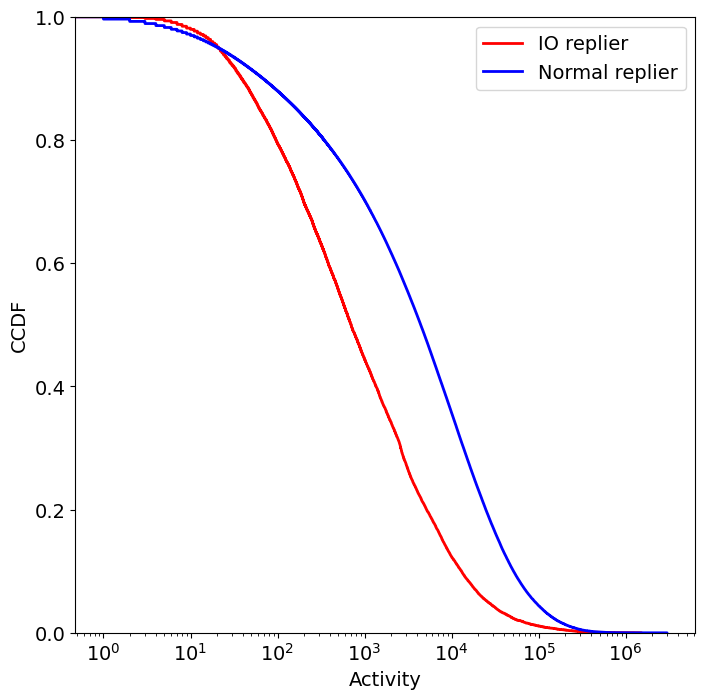

In [5]:
import helper.visualization as viz_hp

importlib.reload(config_hp)
importlib.reload(viz_hp)

parameters = {
        'data': [df_pos, 
                 df_non_io_activity
                ],
        'fontsize': 14,
        'complementary': True,
        'columns': [
            {'column': 'count',
             'label': 'IO replier',
            },{
            'column': 'tweet_count',
             'label': 'Normal replier'
            },
        ],
        'xlabel': 'Activity',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        'log_yscale': False,
        'log_xscale': True,
        'save': {
            'path': './',
            'filename': 'CCDF_tweet_activity_replier.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

In [6]:
df_pos['detected_year'] = pd.to_datetime(df_pos['detected_year'])
df_pos[f'account_creation_date'] = pd.to_datetime(df_pos[f'account_creation_date'])

df_pos['age'] = round((df_pos['detected_year'] - df_pos['account_creation_date']) / np.timedelta64(1, 'Y') + 2)

In [7]:
print(df_pos[['detected_year', 'account_creation_date', 'age']].head(1))

  detected_year account_creation_date   age
0    2019-01-01            2008-01-12  13.0


In [8]:
df_pos[['age']].min()

age    1.0
dtype: float64

In [9]:
print('Max :', df_pos['count'].max())
print('Min :', df_pos['count'].min())

Max : 1512075
Min : 1


In [10]:
#### AGE of the non_io_repliers

non_io_activity = characteristic['non_io_activity']

df_non_io_activity = pd.read_pickle(non_io_activity)

df_non_io_activity['created_at'] = pd.to_datetime(df_non_io_activity['created_at'])

df_non_io_activity['detected_year'] = pd.to_datetime('2023')
df_non_io_activity[f'created_at_year'] = pd.to_datetime(
    df_non_io_activity.created_at.map(lambda x: x.strftime('%Y-%m-%d'))
)

print(df_non_io_activity['created_at_year'].head())

df_non_io_activity['age'] = round((df_non_io_activity['detected_year'] - df_non_io_activity['created_at_year']) / np.timedelta64(1, 'Y') + 1)

2   2011-08-16
3   2017-03-12
4   2014-07-13
6   2015-09-07
7   2016-01-29
Name: created_at_year, dtype: datetime64[ns]


In [11]:
df_non_io_activity[['detected_year', 'created_at', 'age']].head(1)

,detected_year,created_at,age
2,2023-01-01,2011-08-16 21:40:53+00:00,12.0


In [12]:
df_non_io_activity[['age']].min()

age    1.0
dtype: float64

In [13]:
df_non_io_activity.loc[df_non_io_activity['tweet_count'] == -1, 'tweet_count'] = 0

In [14]:
print('Max :', df_non_io_activity['tweet_count'].max())
print('Min :', df_non_io_activity['tweet_count'].min())

Max : 2977733.0
Min : 0.0


In [15]:
df_non_io_activity['tweet_count_by_age'] = df_non_io_activity['tweet_count']/df_non_io_activity['age'] + 1

In [16]:
df_pos['tweet_count_by_age'] = df_pos['count']/df_pos['age'] + 1

In [17]:
print('Min : ', df_pos['tweet_count_by_age'].min())
print('Max : ', df_pos['tweet_count_by_age'].max())

print('Min : ', df_non_io_activity['tweet_count_by_age'].min())
print('Max : ', df_non_io_activity['tweet_count_by_age'].max())

Min :  1.25
Max :  156908.5
Min :  1.0
Max :  358777.5


In [18]:
df_pos.columns

Index(['userid', 'detected_year', 'count', 'account_creation_date', 'age',
       'tweet_count_by_age'],
      dtype='object')

In [20]:
print('Positive :', df_pos['tweet_count_by_age'].mean())
print('Negative :', df_non_io_activity['tweet_count_by_age'].mean())

Positive : 1479.202338238871
Negative : 2188.0730040519497


#### **Viz**

/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/CDF_tweet_count_by_age_ratio_replier.png
/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/CDF_tweet_count_by_age_ratio_replier.png


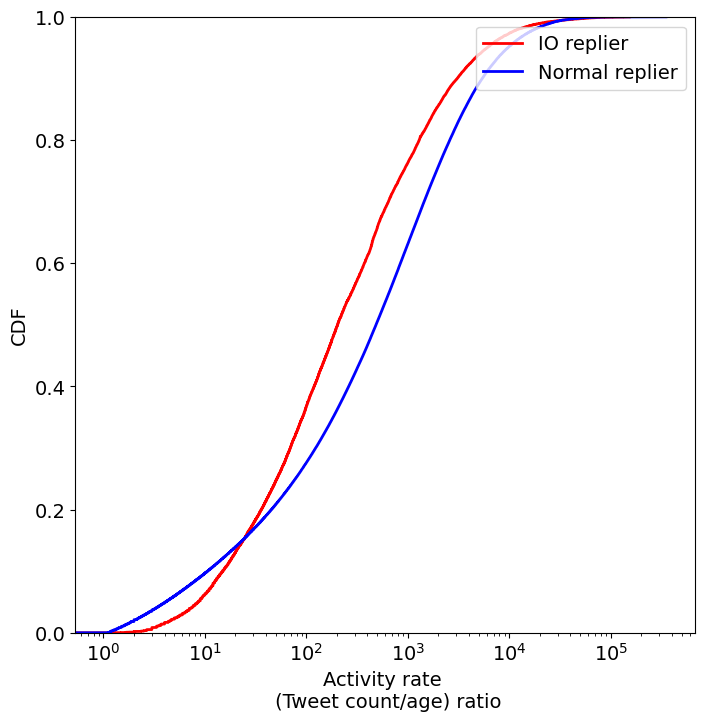

In [17]:
import helper.visualization as viz_hp

importlib.reload(config_hp)
importlib.reload(viz_hp)

config = config_hp.config()
plot_path = config['PLOTS']
reply_plot_path = plot_path['reply_plot_path']

parameters = {
        'data': [df_pos, 
                 df_non_io_activity
                ],
        'fontsize': 14,
        'complementary': False,
        'columns': [
            {'column': 'tweet_count_by_age',
             'label': 'IO replier',
            },{
            'column': 'tweet_count_by_age',
             'label': 'Normal replier'
            },
        ],
        'xlabel': 'Activity rate \n (Tweet count/age) ratio',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        'log_yscale': False,
        'log_xscale': True,
        'save': {
            'path': reply_plot_path,
            'filename': 'CDF_tweet_count_by_age_ratio_replier.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

In [107]:
config = config_hp.config()
characteristic = config['CHARACTERISTICS']

non_io_activity = characteristic['non_io_activity']

df_non_io_activity.to_pickle(non_io_activity)

io_activity = characteristic['io_activity']

df_pos.to_pickle(io_activity)